In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque


In [19]:
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x and y values in last frame
        self.x = None
        self.y = None

        # x intercepts for average smoothing
        self.bottom_x = deque(maxlen=frame_num)
        self.top_x = deque(maxlen=frame_num)

        # Record last x intercept
        self.current_bottom_x = None
        self.current_top_x = None


        # Polynomial coefficients: x = A*y**2 + B*y + C
        self.A = deque(maxlen=frame_num)
        self.B = deque(maxlen=frame_num)
        self.C = deque(maxlen=frame_num)
        self.fit = None
        self.fitx = None
        self.fity = None

    def get_intercepts(self):
        bottom = self.fit[0] * 720 ** 2 + self.fit[1] * 720 + self.fit[2]
        top = self.fit[2]
        return bottom, top

    def quick_search(self, nonzerox, nonzeroy, image):
        """
        Assuming in last frame, lane has been detected. Based on last x/y coordinates, quick search current lane.
        """
        x_inds = []
        y_inds = []
        out_img = np.dstack((image, image, image)) * 255
        if self.detected:
            win_bottom = 720
            win_top = 630
            while win_top >= 0:
                yval = np.mean([win_top, win_bottom])
                xval = (np.median(self.A)) * yval ** 2 + (np.median(self.B)) * yval + (np.median(self.C))
                x_idx = np.where((((xval - 50) < nonzerox)
                                  & (nonzerox < (xval + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                cv2.rectangle(out_img, (int(xval - 50), win_top), (int(xval + 50), win_bottom),
                              (0, 255, 0), 2)
                if np.sum(x_window) != 0:
                    np.append(x_inds, x_window)
                    np.append(y_inds, y_window)
                win_top -= 90
                win_bottom -= 90
        if np.sum(x_inds) == 0:
            self.detected = False  # If no lane pixels were detected then perform blind search
        return x_inds, y_inds, out_img

    def blind_search(self, nonzerox, nonzeroy, image):
        """
        Sliding window search method, start from blank.
        """
        x_inds = []
        y_inds = []
        out_img = np.dstack((image, image, image)) * 255
        if self.detected is False:
            win_bottom = 720
            win_top = 630
            histogram_complete = np.sum(image[200:, :], axis=0)
            while win_top >= 0:
                histogram = np.sum(image[win_top:win_bottom, :], axis=0)
                if self == right:
                    base = (np.argmax(histogram[640:-60]) + 640) \
                    if np.argmax(histogram[640:-60]) > 0\
                    else (np.argmax(histogram_complete[640:]) + 640)
                else:
                    base = np.argmax(histogram[:640]) \
                        if np.argmax(histogram[:640]) > 0 \
                        else np.argmax(histogram_complete[:640])
                x_idx = np.where((((base - 50) < nonzerox) & (nonzerox < (base + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                cv2.rectangle(out_img, (int(base - 50), win_top), (int(base + 50), win_bottom),
                              (0, 255, 0), 2)
                if np.sum(x_window) != 0:
                    x_inds.extend(x_window)
                    y_inds.extend(y_window)
                win_top -= 90
                win_bottom -= 90
        if np.sum(x_inds) > 0:
            self.detected = False
        else:
            y_inds = self.y
            x_inds = self.x
        return x_inds, y_inds, out_img
    def sort_idx(self):
        """
        Sort x and y according to y index
        """
        sorted_idx = np.argsort(self.y)
        sorted_x_inds = self.x[sorted_idx]
        sorted_y_inds = self.y[sorted_idx]

        return sorted_x_inds, sorted_y_inds

    def get_fit(self):
        """
        Based on searched x and y coordinates, polyfit with second order.
        Take median value in previous frames to smooth.
        """
        self.fit = np.polyfit(self.y, self.x, 2)

        self.current_bottom_x, self.current_top_x = self.get_intercepts()

        self.bottom_x.append(self.current_bottom_x)
        self.top_x.append(self.current_top_x)
        self.current_bottom_x = np.median(self.bottom_x)
        self.current_top_x = np.median(self.top_x)

        self.x = np.append(self.x, self.current_bottom_x)
        self.x = np.append(self.x, self.current_top_x)
        self.y = np.append(self.y, 720)
        self.y = np.append(self.y, 0)

        self.x, self.y = self.sort_idx()
        self.fit = np.polyfit(self.y, self.x, 2)
        self.A.append(self.fit[0])
        self.B.append(self.fit[1])
        self.C.append(self.fit[2])
        self.fity = self.y
        self.fit = [np.median(self.A), np.median(self.B), np.median(self.C)]
        self.fitx = self.fit[0] * self.fity ** 2 + self.fit[1] * self.fity + self.fit[2]

        return self.fit, self.fitx, self.fity


In [20]:
def draw_area(undist, left_fitx, lefty, right_fitx, righty):
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros(img_shape[0:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    # pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])

    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])

    pts = np.hstack((pts_left, pts_right))

    # Draw lines
    cv2.polylines(color_warp, np.int_([pts]),
                  isClosed=False, color=(200, 0, 0), thickness=30)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0]))

    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


In [21]:

def car_pos(left_fit, right_fit):
    """
    Calculate the position of car on left and right lane base (convert to real unit meter)
    :param left_fit:
    :param right_fit:
    :return: distance (meters) of car offset from the middle of left and right lane
    """
    xleft_eval = left_fit[0] * np.max(ploty) ** 2 + left_fit[1] * np.max(ploty) + left_fit[2]
    xright_eval = right_fit[0] * np.max(ploty) ** 2 + right_fit[1] * np.max(ploty) + right_fit[2]
    ym_per_pix = 18 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / abs(xleft_eval - xright_eval)  # meters per pixel in x dimension
    xmean = np.mean((xleft_eval, xright_eval))
    offset = (img_shape[1]/2 - xmean) * xm_per_pix  # +: car in right; -: car in left side

    y_eval = np.max(ploty)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * left_fit_cr[0])

    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * right_fit_cr[0])

    mean_curv = np.mean([left_curverad, right_curverad])

    return offset, mean_curv


In [22]:


def undistort(img, mtx, dist):
    """
    Use cv2.undistort to undistort
    :param img: Assuming input img is RGB (imread by mpimg)
    :param mtx: camera calibration parameter
    :param dist: camera calibration parameter
    :return: Undistorted img
    """
    # transform to BGR to fit cv2.imread
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    dst_img = cv2.undistort(img_BGR, mtx, dist, None, mtx)

    return cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)

In [23]:
src = np.float32([[490, 482], [810, 482],
                  [1250, 720], [0, 720]])
dst = np.float32([[0, 0], [1280, 0],
                  [1250, 720], [40, 720]])
def warp(img):
    """
    Perspective Transformation
    :param img:
    :return: warped image
    """

    # Compute and apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [24]:


def camera_calibration():
    global mtx,dist
    # Prepare object points
    obj_pts = np.zeros((6 * 9, 3), np.float32)
    obj_pts[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('C:/Advanced-Lane-Detection-master/camera_cal/*.jpg')
    img = None

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # MUST be 8-bit grayscale or color image
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)

    # Get Image Size
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

In [25]:

camera_calibration()

Text(0.5, 1.0, 'undistorted Image')

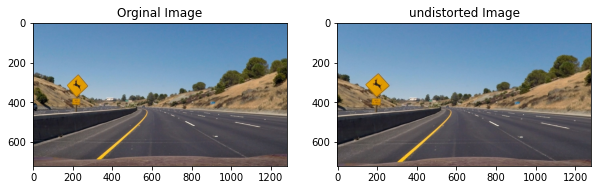

In [26]:
    img=mpimg.imread('C:/Advanced-Lane-Detection-master/test_images/test2.jpg')
    undist_img = undistort(img, mtx, dist)

    plt.figure(figsize=(10, 6))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Orginal Image')
    plt.subplot(222)
    plt.imshow(undist_img)
    plt.title('undistorted Image')

Text(0.5, 1.0, 'warped Image')

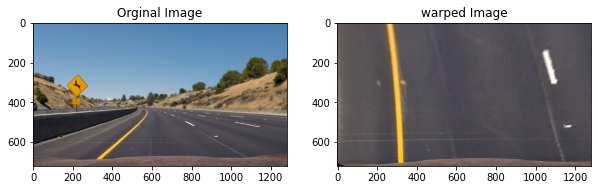

In [27]:
    warped = warp(undist_img)

    plt.figure(figsize=(10, 6))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Orginal Image')
    plt.subplot(222)
    plt.imshow(warped)
    plt.title('warped Image')

In [28]:

def luv_lab_filter(img, l_thresh=(195, 255), b_thresh=(140, 200)):
    l = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:, :, 0]
    l_bin = np.zeros_like(l)
    l_bin[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1

    b = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:, :, 2]
    b_bin = np.zeros_like(b)
    b_bin[(b >= b_thresh[0]) & (b <= b_thresh[1])] = 1

    combine = np.zeros_like(l)
    combine[(l_bin == 1) | (b_bin == 1)] = 1

    return combine

Text(0.5, 1.0, 'Filtered Image')

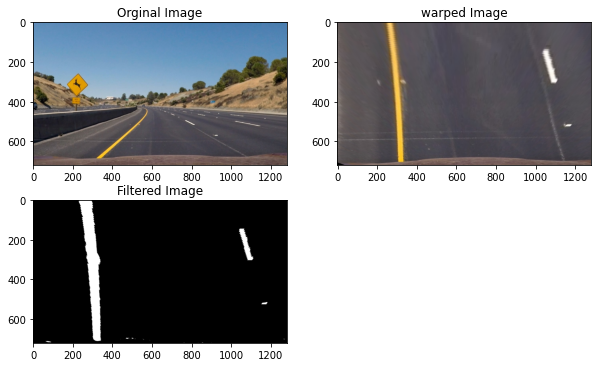

In [29]:
    filtered=luv_lab_filter(warped)

    plt.figure(figsize=(10, 6))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Orginal Image')
    plt.subplot(222)
    plt.imshow(warped)
    plt.title('warped Image')
    plt.subplot(223)
    plt.imshow(filtered,cmap='gray')
    plt.title('Filtered Image')

In [30]:

def vconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in im_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in im_list]
    return cv2.vconcat(im_list_resize)


def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)


def concat_tile_resize(im_list_2d, interpolation=cv2.INTER_CUBIC):
    im_list_v = [hconcat_resize_min(im_list_h, interpolation=cv2.INTER_CUBIC) for im_list_h in im_list_2d]
    return vconcat_resize_min(im_list_v, interpolation=cv2.INTER_CUBIC)

In [31]:

def process_image(img):

    global mtx, dist, src, dst, debug

    undist_img = undistort(img, mtx, dist)

    warped = warp(img)

    warped_binary = luv_lab_filter(warped, l_thresh=(215, 255),
                                   b_thresh=(145, 200))

    nonzerox, nonzeroy = np.nonzero(np.transpose(warped_binary))

    if left.detected is True:
        leftx, lefty, out_img_left = left.quick_search(nonzerox, nonzeroy, warped_binary)
    if right.detected is True:
        rightx, righty, out_img_right = right.quick_search(nonzerox, nonzeroy, warped_binary)
    if left.detected is False:
        leftx, lefty, out_img_left = left.blind_search(nonzerox, nonzeroy, warped_binary)
    if right.detected is False:
        rightx, righty, out_img_right = right.blind_search(nonzerox, nonzeroy, warped_binary)


    out_combine = cv2.addWeighted(out_img_left, 1, out_img_right, 0.5, 0)

    left.y = np.array(lefty).astype(np.float32)
    left.x = np.array(leftx).astype(np.float32)
    right.y = np.array(righty).astype(np.float32)
    right.x = np.array(rightx).astype(np.float32)

    left_fit, left_fitx, left_fity = left.get_fit()
    right_fit, right_fitx, right_fity = right.get_fit()

    offset, mean_curv = car_pos(left_fit, right_fit)

    result = draw_area(undist_img, left_fitx, left_fity, right_fitx, right_fity)

    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature: %d(m)'
    text2 = 'Offset from center: %.2f(m)'
    text3 = 'Radius of Curvature: Inf (m)'

    if mean_curv < 3000:
        cv2.putText(result, text1 % (int(mean_curv)),
                                  (60, 100), font, 1.0, (255, 255, 255), thickness=2)
    else:
        cv2.putText(result, text3,
                    (60, 100), font, 1.0, (255, 255, 255), thickness=2)
    cv2.putText(result, text2 % (-offset),
                              (60, 130), font, 1.0, (255, 255, 255), thickness=2)

    if debug:
        warped_binary_t=np.dstack((warped_binary,warped_binary,warped_binary))*255
        result = concat_tile_resize([[result], [undist_img, warped,warped_binary_t,out_combine]])

    return result

In [32]:
def draw(img):
    undist_img = undistort(img, mtx, dist)

    warped = warp(img)

    warped_binary = luv_lab_filter(warped, l_thresh=(215, 255),
                                   b_thresh=(145, 200))

    out = process_image(img)

    plt.figure(figsize=(10, 6))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Orginal Image')
    plt.subplot(222)
    plt.imshow(warped)
    plt.title('Perspective Transformation')
    plt.subplot(223)
    plt.imshow(warped_binary,cmap='gray')
    plt.title('Filter Output')
    plt.subplot(224)
    plt.imshow(out)
    plt.title('Lane Detection')
    plt.show()
    return

Image  0 :  D:/Downloads/Project_data/test_images\straight_lines1.jpg


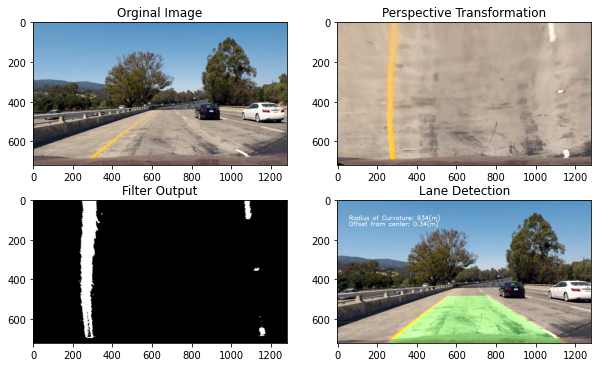

Image  1 :  D:/Downloads/Project_data/test_images\straight_lines2.jpg


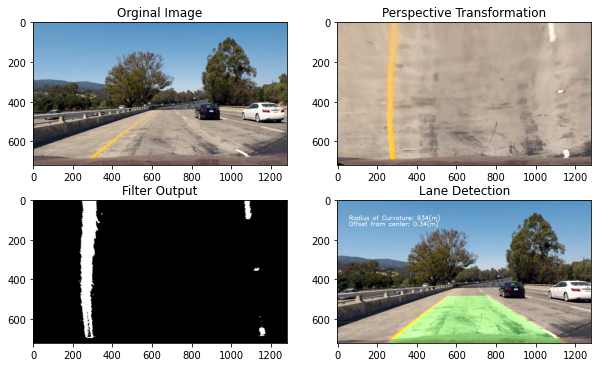

Image  2 :  D:/Downloads/Project_data/test_images\test1.jpg


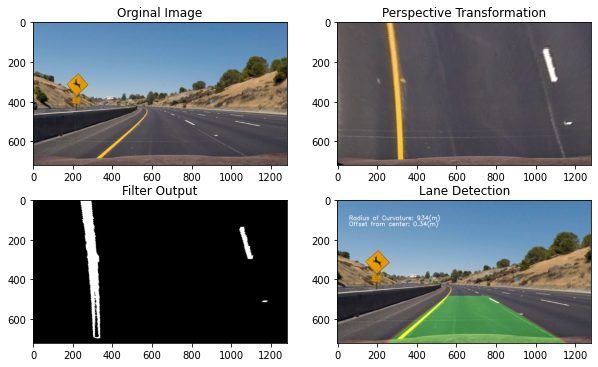

Image  3 :  D:/Downloads/Project_data/test_images\test2.jpg


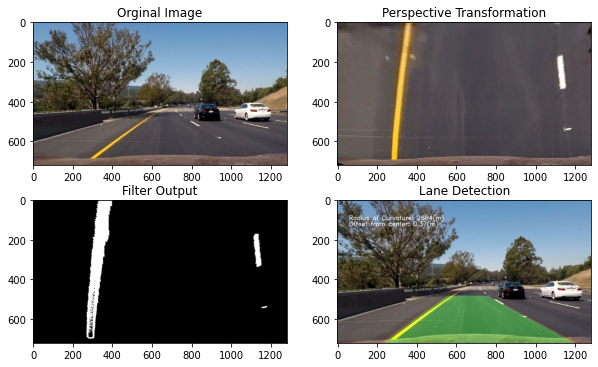

Image  4 :  D:/Downloads/Project_data/test_images\test3.jpg


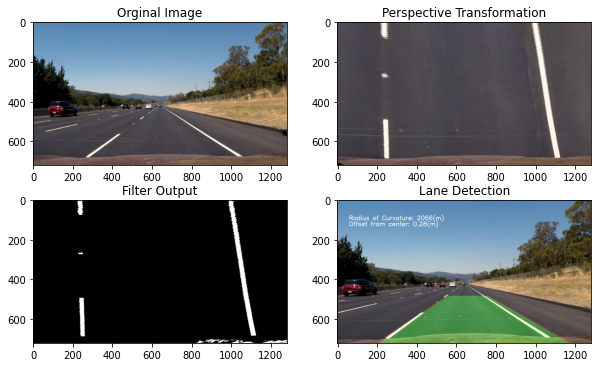

Image  5 :  D:/Downloads/Project_data/test_images\test4.jpg


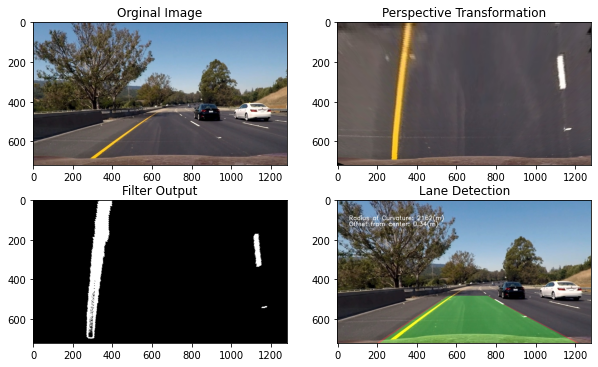

Image  6 :  D:/Downloads/Project_data/test_images\test5.jpg


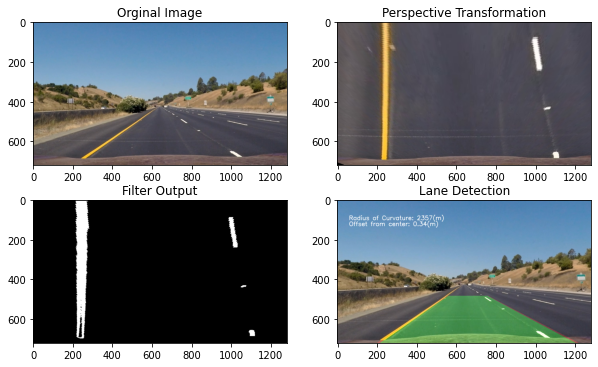

Image  7 :  D:/Downloads/Project_data/test_images\test6.jpg


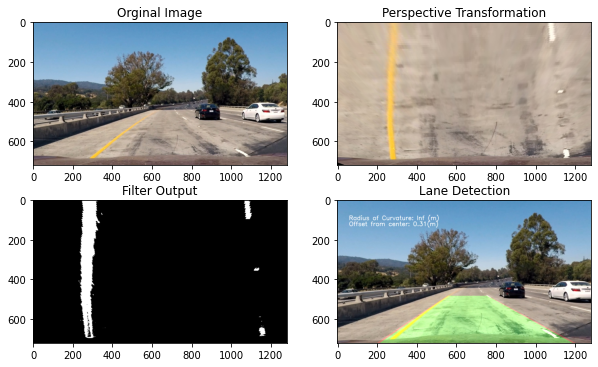

In [33]:

img_shape = (720, 1280)
img_size = [1280, 720]  # width, height


ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
debug = True


mtx = None
dist = None
camera_calibration()
debug = False
frame_num = 15   # latest frames number of good detection
left = Line()
right = Line()

video_output = 'D:/output.mp4'
input_path = 'D:/Downloads/Project_data/project_video.mp4'
image_name = 'test6'

images = glob.glob('D:/Downloads/Project_data/test_images/*.jpg')
for i in range(len(images)):
    print("Image ", i, ": " ,images[i] )

    choice = np.random.choice(len(images))

    img = cv2.imread(images[choice])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw(img)
debug = True
# for video writing
#clip1 = VideoFileClip(input_path)
#final_clip = clip1.fl_image(process_image)
#final_clip.write_videofile(video_output, audio=False)